# Lab 1 : Visualization and Data Processing

## Group 4 :  Simerpreet Reddy, Rudranil Mitra, Samuel VonPaays Soh, Kristi Herman

Nbviewer Link -> https://nbviewer.jupyter.org/github/RudranilMitra/DS7331_Lab1/blob/main/gp1.ipynb


---
## <font color='darkgreen'> Business Understanding </font>

The source selected for this analysis is a Craigslist used car listings dataset from Kaggle:  https://www.kaggle.com/austinreese/craigslist-carstrucks-data<br>  The author of this dataset used web scraping algorithms to scrape the information for used vehicles from all regional Craigslist's sites in the U.S that were posted between 10/28/2020 and 12/3/2020.  The original dataset contained <b>458,213 rows</b> with <b>26 fields</b>. 


#### <font color='green'>Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?)</font>
The purpose of this dataset is to collect data for all used cars and trucks for sale in the U.S. that are listed on Craigslist regional sites.  This dataset was selected to model and predict used car prices and to classify price ranges by categories.  Included in the dataset were other types of vehicles such as buses and motorcycles.  Those records were removed to limit the analysis to cars and trucks only. Those records were removed to limit the analysis to cars and trucks only. In this analysis, any references to "car" includes cars and trucks.




#### <font color='green'>Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? </font>

We will know that we have mined useful knowledge if we are able to come up with a good prediction for used car prices and a classifier for price range predictions. In other words, a good model will be able to find relationships among the predictors and the response variables.  

#### <font color='green'>How would you measure the effectiveness of a good prediction algorithm? Be specific. </font>

Our goal is to run both both regression and classification algorithms on this dataset. For the regression problem of predicting car prices, RMSE along with k-fold cross validation will be used to determine the effectiveness of the prediction. For the classification problem, k-fold cross validation with accuracy, precision, recall, True Positive Rate, and False Positive Rate will be used to measure the effectiveness of the prediction model. The value for 'k' in cross validation will be determined through hyperparameter tuning during the model building process.

## <font color='darkgreen'> Data Meaning Type </font>

*Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.*

In [4]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import requests
import json
import time
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc
import folium
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.formula.api import ols

In [5]:
#import vehicle dataset
orig_df = pd.read_csv('data/vehicles.csv') 

<blockquote>The original dataset contained <b>458,213 rows</b> with <b>26 fields</b>. 

In [6]:
# Copy original file to car_df to avoid reloading the large file, keep the original dataset in case it is needed. 
car_df = orig_df.copy()

#info
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    458213 non-null  int64  
 1   id            458213 non-null  int64  
 2   url           458213 non-null  object 
 3   region        458213 non-null  object 
 4   region_url    458213 non-null  object 
 5   price         458213 non-null  int64  
 6   year          457163 non-null  float64
 7   manufacturer  439993 non-null  object 
 8   model         453367 non-null  object 
 9   condition     265273 non-null  object 
 10  cylinders     287073 non-null  object 
 11  fuel          454976 non-null  object 
 12  odometer      402910 non-null  float64
 13  title_status  455636 non-null  object 
 14  transmission  455771 non-null  object 
 15  VIN           270664 non-null  object 
 16  drive         324025 non-null  object 
 17  size          136865 non-null  object 
 18  type

<blockquote>These fields(below) were immediately dropped for the following reasons:<br>
1) The features were not useful for the two prediction problems in this analysis (id, Unnamed:0, url, image_url, region_url, description)<br>
2) There were too many missing values that could not be easily derived (size) <br> 
3) The features provided similar location information to the "state" feature (region, lat, long were dropped and state was kept)

In [7]:
car_df = car_df.drop(columns=['id', 'Unnamed: 0', 'url', 'image_url',
                              'region_url', 'description', 'size', 'region', 'lat', 'long'])

<blockquote>This is a more detailed description of the fields that will be used for explanatory and response variables after some transformations are applied in <a href='#dataquality'>Data Quality</a> .  The first two variables listed are the ones that will be predicted - price and price_range. </blockquote> 
   

In [8]:
%%html
<style>
table {float:left}
</style>

|<p>Field Name|<p>Description|Type|Scale|
|:-----|:-----|:-----|:-----|
|<p>price |<p>The price of the vehicle in US dollars. |integer |ratio |
|<p>price_range |<p>Price category derived from the "price" field, e.g., <1,000, 1,000 - 5,000, 5,000 - 10,000, etc. |category |ordinal |
|<p>manufacturer |<p>Manufacturer of the vehicle, e.g., honda, jeep, etc.  There are 40 unique values. |category |nominal |
|<p>model |<p>Model of the vehicle, e.g., f150, malibue, etc.  There are around 13,000 unique models. |category |nominal |
|<p>condition_new |<p>Condition of the car with 4 values (salvage, fair_good, excellent_likenew, new).  This field combined some of the values in the original "condition" field. |category |ordinal |
|<p>cylinders |<p>Number of cylinders in the car ranging from 2 to 12. |integer |interval |
|<p>fuel |<p>Type of fuel with the following categories:  'gas', 'diesel', 'other', 'hybrid', 'electric'. |category |nominal |
|<p>odometer |<p>Mileage listed for the vehicle. |integer |ratio |
|<p>title_status |<p>The title status is of the vehicle:  'clean', 'lien', 'missing', 'salvage', 'rebuilt', 'parts only'. |category |nominal |
|<p>transmission_new |<p>Type of transmission:   'other', 'automatic', 'manual'.  This field combined some of the categories from the original 'transmission' field.  The 'other' category includes semi-automatic and dual clutch vehicles. |category |nominal |
|<p>drive_new |<p>Type of drive: ' rwd', 'fwd', '4wd', 'other'. |category |nominal |
|<p>type_new |<p>Type of vehicle with 9 categories after combining some from the original types:  'sedan', 'pickup_truck', 'coupe', 'crossover', 'mini-van','convertible', 'hatchback', 'van', 'offroad'. |category |nominal |
|<p>paint_color_new |<p>Color of the vehicle with 4 categories after combining some from the original colors:   'BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom'. |category |nominal 
|<p>state |<p>State the vehicle is being sold in.  All 50 states are represented as well as a category for D.C. |category |nominal |
|<p>car_Age_in_yrs |<p>Derived by subtracting the original year of the vehicle from the date of the Craigslist posting. |integer |ratio |

All the categorical variables will be One Hot Encoded in the [New Features](#New-Features) section below.

## <font color='darkgreen'> Data Quality </font>
*Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Give justifications for your methods.*

### Missing values

<blockquote>There were a significant number of missing values in the original dataset. The first step taken to address this was to attempt to get the missing values from the Department of Transportation's VIN API (https://vpic.nhtsa.dot.gov/api/) based on VIN number.  From there, the records that had missing values were dropped or combined into "other" categories.  More details for each field are outlined below.

In [9]:
#n/a's before getting Dept. of Transportation data
car_df.isna().sum()

price                0
year              1050
manufacturer     18220
model             4846
condition       192940
cylinders       171140
fuel              3237
odometer         55303
title_status      2577
transmission      2442
VIN             187549
drive           134188
type            112738
paint_color     140843
state                0
posting_date        28
dtype: int64

<blockquote>Cylinders, year, fuel, drive, transmission, and model were available from the Department of Transportation.  A python wrapper was built to retrieve the data from ReST endpoints based on VIN number of records with missing data.  More details about the scraper are in the <a href='#exceptional'>Exceptional section</a>. Once the data was retrieved, it was exported to a separate csv (vin_data.csv) and imported and merged into car_df to fill in missing values by VIN.

In [10]:
#import VIN dataset
vin_df  = pd.read_csv('data/vin_data.csv',sep='|', encoding='latin-1')

In [11]:
class MergeTransform(BaseEstimator, TransformerMixin):
    def __init__(self, original_dataset, column_map, columns_to_drop, join_column):
        self.original_dataset = original_dataset
        self.column_map = column_map
        self.columns_to_drop = columns_to_drop
        self.join_column = join_column
    #

    def fit(self, X, y=None):
        return self
    #

    def transform(self, X, y=None):
        #
        X = X.drop_duplicates(['VIN'])
        #
        merged_dataset = pd.merge(
            self.original_dataset, X, how='left', on=self.join_column)
        #
        for k, v in self.column_map:
            merged_dataset[k].fillna(merged_dataset[v], inplace=True)
        #
        merged_dataset.drop(self.columns_to_drop, axis=1, inplace=True)
        merged_dataset['cylinders'] = merged_dataset['cylinders'].replace(
            {'cylinders': ''}, regex=True)
        #
        return merged_dataset


# The datasets will be joined on VIN
join_col = ['VIN']

# These are the columns that are being cleaned up. The column on the left is the from the cars dataset. These columns
# have null values and need to be replaced from the VIN dataset
column_transform_map = [['cylinders', 'EngineCylinders'],
                        ['year', 'ModelYear'],
                        ['fuel', 'FuelTypePrimary'],
                        ['drive', 'DriveType'],
                        ['transmission', 'TransmissionStyle'],
                        ['model', 'Model']]

# These are additional columns from the VIN dataset an can be dropped after the merge
columns_to_drop = ['DriveType', 'EngineCylinders', 'EngineManufacturer', 'EngineModel', 'Make', 'Manufacturer',
                   'Model', 'ModelYear', 'PlantCompanyName', 'TransmissionSpeeds', 'TransmissionStyle', 'FuelTypePrimary']

# Create an instance of the transformer
transformer = MergeTransform(
    car_df, column_transform_map, columns_to_drop, join_col)

# Run the transformer to generate the clean dataset
car_df = transformer.transform(vin_df)


<blockquote>After merging the original dataset with the VIN dataset, the missing values have been reduced. We can see the differences in the table that mentions the before and after counts

In [12]:
#n/as after getting Dept. of Transportation data
car_df.isna().sum()

price                0
year               145
manufacturer     18220
model             3837
condition       192940
cylinders        80402
fuel               415
odometer         55303
title_status      2577
transmission      1940
VIN             187549
drive            92235
type            112738
paint_color     140843
state                0
posting_date        28
dtype: int64

| Column | Before Merge Null Count| After Merge Null Count|
| --- | --- | --- |
price        |     0 |       0 |
year         |  1050 |     145 |
manufacturer | 18220 |   18220 |
model        |  4846 |    3837 |
condition    |192940 |  192940 |
cylinders    |171140 |   80402 |
fuel         |  3237 |     415 |
odometer     | 55303 |   55303 |
title_status |  2577 |    2577 |
transmission |  2442 |    1940 |
VIN          |187549 |  187549 |
drive        |134188 |   92235 |
type         |112738 |  112738 |
paint_color  |140843 |  140843 |
state        |     0 |       0 |
posting_date |    28 |      28 |


<blockquote>The VIN column was then dropped since it was no longer needed for the analysis.

In [13]:
#drop extra ID fields, URL fields, region fields, and description
car_df = car_df.drop(columns=['VIN'])

<blockquote>For eight of the columns that still have missing data and no source to obtain it, the rows with missing values were dropped (condition, title_status, drive, fuel, model, manufacturer, type, and year).  Since these columns seemed to be important for predicition, it was determined that these columns not be dropped from the dataset. The remaining n/a's are combined with other fields in the section below for <a href='#recategorization'>Re-Categorizing Data</a>.

In [14]:
#drop rows with n/a for important variables that couldn't be obtained from the dept. of transportation
car_df = car_df[car_df['condition'].notna()]
car_df = car_df[car_df['title_status'].notna()]
car_df = car_df[car_df['drive'].notna()]
car_df = car_df[car_df['fuel'].notna()]
car_df = car_df[car_df['model'].notna()]
car_df = car_df[car_df['manufacturer'].notna()]
car_df = car_df[car_df['type'].notna()]
car_df['year'].dropna(inplace=True)

### Outliers

Price, year, and odometer had some major outliers. A lot of the extreme outliers seemed to be mistakes (e.g., 3.5 billion for price, 1900 for year). We implemented quantile method to screen out the outliers. We set the upper limit for the quantile to be 0.99 and lower limit to be 0.01. <p>

Year. The number of count for year reduced from 203,001 to 173,449 while the IQR ( delta between Q1- 25th percentiles and Q3-75th percentiles) stay the same. The mean of the two is about the same between 2010 and 2011. The left tail of the year distribution pull back significantly from 1900 to 1970 due to this outlier screening. <p>

Odometer. The number of count reduced from 191,762 to 173,449. IQR is quite close between the two (94,328(screened) vs 97,066). The std deviation is greatly improved from 4,677,272 to 59,592. The max of odometer reading changed from 2,043,756,000 (make no sense) to 269,781. <p>

Price. The price has several extreme outliers which can go as high as $3.6 billion. The count reduced from 203,001 to 173,449. The IQR is quite close between the two ( 16,495vs 16,074). The std devication is improved with outlier screening from 8,038,314 to 11,041.  <p>

In [15]:
# use quantile to remove outliers
# creating a new data frame car_df1 to compare the before and after snapshot from the outlier correction.
# we will later copy back car_df1 to car_df for easier code readability

q_hi = car_df['price'].quantile(0.99)
q_low = car_df['price'].quantile(0.01)
car_df1 = car_df[(car_df['price'] < q_hi) & (car_df['price'] > q_low)]

q_hi = car_df1['year'].quantile(0.99)
q_low = car_df1['year'].quantile(0.01)
car_df1 = car_df1[(car_df1['year'] < q_hi) & (car_df1['year'] > q_low)]

q_hi = car_df1['odometer'].quantile(0.99)
q_low = car_df1['odometer'].quantile(0.01)
car_df1 = car_df1[(car_df1['odometer'] < q_hi) & (car_df1['odometer'] > q_low)]

<blockquote>Summary for price, year, odometer before removing outliers. Seeing the boxplots, we can conclude that there are outliers that are skewing the data

In [16]:
car_df[['price','year','odometer']].describe()

,price,year,odometer
count,2.030010e+05,203001.000000,1.917620e+05
mean,3.524055e+04,2010.890168,1.061668e+05
std,8.038314e+06,8.010294,4.677272e+06
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.500000e+03,2008.000000,3.766400e+04
50%,1.195000e+04,2013.000000,8.574700e+04
75%,2.199500e+04,2016.000000,1.347300e+05
max,3.615215e+09,2021.000000,2.043756e+09


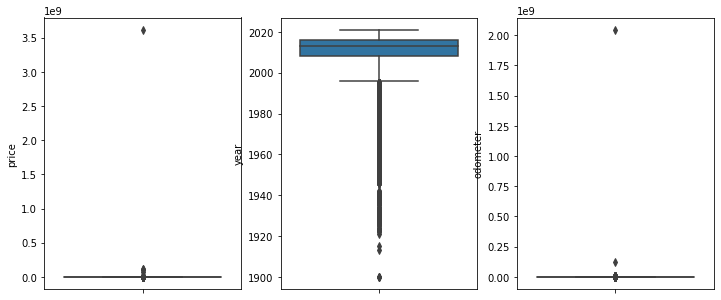

In [17]:
# boxplots before removing the outliers
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
sns.boxplot(y=car_df['price'], ax=axs[0])
sns.boxplot(y=car_df['year'], ax=axs[1])
sns.boxplot(y=car_df['odometer'], ax=axs[2])
plt.show()

<blockquote>The data and boxplot reflects that the skewed observations are removed after removing outliers 

In [18]:
car_df1[['price','year','odometer']].describe()

,price,year,odometer
count,173449.000000,173449.000000,173449.000000
mean,15294.256813,2011.298024,94339.717652
std,11041.568001,5.945514,59592.115171
min,1.000000,1977.000000,181.000000
25%,6426.000000,2008.000000,42347.000000
50%,12590.000000,2013.000000,90000.000000
75%,22500.000000,2016.000000,136675.000000
max,52948.000000,2019.000000,269781.000000


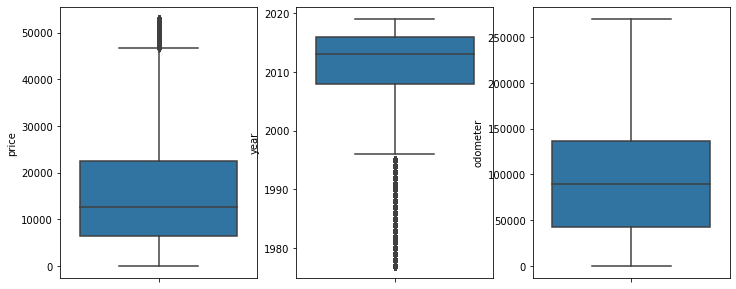

In [19]:
# boxplots after removing the outliers
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
sns.boxplot(y=car_df1['price'], ax=axs[0])
sns.boxplot(y=car_df1['year'], ax=axs[1])
sns.boxplot(y=car_df1['odometer'], ax=axs[2])
plt.show()

### <a id="recategorization">Re-Categorizing Data</a>

<blockquote>The drive type of a vehicle indicates the type of climate and conditions that the vehicle is optimized for.  After retrieving data from the Dept. of Transportation, there were some text mismatches that represented the same types of drives.  After re-categorizing, these are the final categories:<p>
    
    rwd:  Rear-wheel drive 
    4wd:  Four-wheel drive
    fwd:  Front-wheel drive
    others:  As indicated by the seller or when no value was specified.  Glider was categorized here as well.

In [20]:
# Copy back car_df1 to car_df 
car_df = car_df1.copy()

In [21]:
# Regroup different drive types
drive_types = [
    # begin transformation for 4wd
    (car_df['drive'] == "4WD/4-Wheel Drive/4x4") | 
    (car_df['drive'] == "4wd") | 
    (car_df['drive'] == "4WD/4-Wheel Drive/4x4") | 
    (car_df['drive'] == "2WD/4WD") | 
    (car_df['drive'] == "6x4") | 
    (car_df['drive'] == "6x2") | 
    (car_df['drive'] == "AWD/All Wheel Drive"),
    # begin transformation for fwd
    (car_df['drive'] == "4x2") | 
    (car_df['drive'] == "2WD/4WD") | 
    (car_df['drive'] == "FWD/Front Wheel Drive") | 
    (car_df['drive'] == "fwd"),
    # begin transformation for rwd
    (car_df['drive'] == "RWD/ Rear Wheel Drive") | 
    (car_df['drive'] == "rwd"),
    # begin transformation for others
    (car_df['drive'] == "Not Applicable") | 
    (car_df['drive'] == "Other") | 
    (car_df['drive'] == "Glider")
]

# new drive categories
drive_values = ['4wd', 'fwd', 'rwd', 'others']

# new drive column
car_df['drive_new'] = np.select(drive_types, drive_values)
car_df['drive_new'].unique()


array(['rwd', 'fwd', '4wd', 'others'], dtype=object)

<blockquote>One of the goals of this project is to predict categorical responses for price range.  A new category field named "price_range" was derived from the "price" field. These are the final categories:
    
    < 1K
    1K-5K 
    5K-10K 
    10K-15K
    15k-30K 
    30K-50K 
    > 50K
    

In [22]:
#Create column price_range to classify price of a car into one of the following groups: ('<1K' < '1K-5K' < '5K-10K' < '10K-15K' < '15k-30K' < '30K-50K' < '>50K'etc.)

car_df['price_range'] = pd.cut(x=car_df['price'], bins=[-1, 
                                                        1000, 
                                                        5000,
                                                        10000,
                                                        15000,
                                                        30000,
                                                        50000, 
                                                        100000],
                                                 labels=['<1K', 
                                                         '1K-5K', 
                                                         '5K-10K',
                                                         '10K-15K', 
                                                         '15k-30K',
                                                         '30K-50K', 
                                                         '>50K' ])
car_df['price_range'].unique()

['30K-50K', '5K-10K', '15k-30K', '1K-5K', '10K-15K', '<1K', '>50K']
Categories (7, object): ['<1K' < '1K-5K' < '5K-10K' < '10K-15K' < '15k-30K' < '30K-50K' < '>50K']

<blockquote>"Condition" of the vehicles is determined by the seller.  Because some of them were very similar, they were re-grouped to a condition_new field with these final categories:
    
    salvage
    good_fair
    excellent_likenew
    new

In [23]:
#combine conditions to 4 categories with the following groupings ('good', 'fair'), ('excellent','like new'), 'salvage', 'new' 
conditions = [
    # begin transformation for good_fair
    (car_df['condition'] == "good") | 
    (car_df['condition'] == "fair"),
    (car_df['condition'] == "excellent") | 
    # begin transformation for excellent_likenew
    (car_df['condition'] == "like new"),
    # begin transformation for salvage
    (car_df['condition'] == "salvage"),
    # begin transformation for new
    (car_df['condition'] == "new")
    ]

#new condition categories
values = ['good_fair', 'excellent_likenew', 'salvage', 'new']

#new condition column
car_df['condition_new'] = np.select(conditions, values)
car_df['condition_new'].unique()

array(['good_fair', 'excellent_likenew', 'new', 'salvage'], dtype=object)

In [24]:
#drop the original condition field
car_df = car_df.drop(columns=['condition'])

#drop the original  drive field
car_df = car_df.drop(columns=['drive'])

<blockquote>'Transmission' types had a similar issue to drives in that different text values represented the same thing after the Dept. of Transportation data was retrieved.  This field was regrouped into a 'transmission_new' field with these final categories: automatic, manual, and other. The "other" field consists of transmissions such as Semi-Automatic and Dual-Clutch.

In [25]:
#Group different transmission categories. 
car_df['transmission'] = car_df['transmission'].fillna('other')
transmission_types = [
    # begin transformation for Automatic
    (car_df['transmission'] == "automatic") | 
    (car_df['transmission'] == "Automatic") | 
    (car_df['transmission'] == "Continuously Variable Transmission (CVT)"),
    # begin transformation for Manual
    (car_df['transmission'] == "manual") | 
    # begin transformation for Other
    (car_df['transmission'] == "Manual/Standard"),
    (car_df['transmission'] == "other")
    ]

#new transmission categories
t_values_types = ['Automatic', 'Manual', 'Other']

#new transmission column
car_df['transmission_new'] = np.select(transmission_types, t_values_types)
car_df['transmission_new'].unique()

array(['Other', 'Automatic', 'Manual'], dtype=object)

In [26]:
#drop the original transmission field
car_df = car_df.drop(columns=['transmission'])

<blockquote>Vehicle 'type' is a classification given by car makers to represent size and shape.  We felt that several were similar to each other so those were grouped together in a 'type_new' field with these final categories: 'sedan', 'pickup_truck', 'coupe', 'crossover', 'mini-van', 'convertible', 'hatchback', 'van', 'offroad'.

In [27]:
#Combine types to: 'sedan', ('wagon','SUV') and call it 'crossover', ('pickup', 'truck'), 'coupe', 'van', 'mini-van', 'convertible', 'hatchback', 'offroad'
car_df['type'] = car_df['type'].fillna('')
car_df = car_df[car_df['type'].isin(['sedan', 'SUV', 'pickup', 'coupe', 'van', 'truck','mini-van', 'wagon', 'convertible', 'hatchback','offroad',''])]

types = [
    # begin transformation for crossover
    (car_df['type'] == "wagon") | 
    (car_df['type'] == "SUV"),
    # begin transformation for pickup_truck
    (car_df['type'] == "pickup") | 
    (car_df['type'] == "truck"),
    # begin transformation for sedan
    (car_df['type'] == "sedan"),
    # begin transformation for coupe
    (car_df['type'] == "coupe"),
    # begin transformation for van
    (car_df['type'] == "van"),
    # begin transformation for mini-van
    (car_df['type'] == "mini-van"),
    # begin transformation for wagon
    (car_df['type'] == "wagon"),
    # begin transformation for convertible
    (car_df['type'] == "convertible"),
    # begin transformation for hatchback
    (car_df['type'] == "hatchback"),
    # begin transformation for offroad
    (car_df['type'] == "offroad"),
    (car_df['type'] == "")
    ]
#new condition categories
values_types = ['crossover', 'pickup_truck', 'sedan', 'coupe','van','mini-van','wagon','convertible','hatchback','offroad','']
#new condition column
car_df['type_new'] = np.select(types, values_types)
car_df.head()
car_df['type_new'].unique()

array(['sedan', 'pickup_truck', 'coupe', 'crossover', 'mini-van',
       'convertible', 'hatchback', 'van', 'offroad'], dtype=object)

In [28]:
#drop the original type field
car_df = car_df.drop(columns=['type'])
car_df['paint_color'] = car_df['paint_color'].fillna('Z')
car_df.drop(car_df[car_df['paint_color']=='Z'].index,inplace=True)
car_df['paint_color'].unique()

array(['blue', 'red', 'silver', 'black', 'white', 'grey', 'green',
       'custom', 'yellow', 'brown', 'orange', 'purple'], dtype=object)

<blockquote>There were originally 14 paint colors. These were grouped together after looking at boxplots to see which ones were similar to each other.  These are the final categories: 
    
    BlSlvrWhGryMsng: Black, Silver, White, Gray.  N/As are included due to a higher probability of being the more popular colors.
    BluRdBrwn:  Blue, Red, and Brown
    OrYlwGrnPrpl: Orange, Yellow, Green, Purple
    Custom:  Custom paint

In [29]:
paint_color_grps = [
    #
    (car_df['paint_color'] == "black") | 
    (car_df['paint_color'] == "silver") | 
    (car_df['paint_color'] == "white")|
    (car_df['paint_color'] == "grey")|
    (car_df['paint_color'] == '')  ,
    #
    (car_df['paint_color'] == "blue") | 
    (car_df['paint_color'] == "red")| 
    #
    (car_df['paint_color'] == "brown"),
    (car_df['paint_color'] == "orange")| 
    (car_df['paint_color'] == "yellow")| 
    (car_df['paint_color'] == "green")| 
    # 
    (car_df['paint_color'] == "purple"),
    (car_df['paint_color'] == "custom")
    ]
#new paint groups
values_paint = ['BlSlvrWhGryMsng', 'BluRdBrwn', 'OrYlwGrnPrpl', 'Custom']
#new condition column
car_df['paint_color_new'] = np.select(paint_color_grps, values_paint)
car_df['paint_color_new'].unique()

array(['BluRdBrwn', 'BlSlvrWhGryMsng', 'OrYlwGrnPrpl', 'Custom'],
      dtype=object)

<blockquote> From a one way ANOVA we can reject the null hypothesis that the  mean prices are equal for all paint groups(p-value < 0.05)

In [30]:
model = ols('price ~ C(paint_color_new)', data=car_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
C(paint_color_new),1.543872e+11,3.0,453.092558,4.934822e-293
Residual,1.629139e+13,143435.0,NaN,NaN


<blockquote> From a Tukey Post Hoc Test we can see there is a significant difference in mean prices across the different paint groups(p-value < 0.05). However, we fail to reject the null hypothesis that the mean prices are different for the group Custom & OrYlwGrnPrpl(Combination of Orange, Yellow, Green, Purple). p-value = 0.6669. We will still keep this in the dataset and let feature selection process guide the results

In [31]:
comp = mc.MultiComparison(car_df['price'], car_df['paint_color_new'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
BlSlvrWhGryMsng,BluRdBrwn,-850.8024,0.001,-1020.4218,-681.1829,True
BlSlvrWhGryMsng,Custom,-4248.6155,0.001,-4776.0717,-3721.1594,True
BlSlvrWhGryMsng,OrYlwGrnPrpl,-4523.5813,0.001,-4908.3225,-4138.8401,True
BluRdBrwn,Custom,-3397.8131,0.001,-3938.1882,-2857.4381,True
BluRdBrwn,OrYlwGrnPrpl,-3672.7789,0.001,-4075.0487,-3270.5091,True
Custom,OrYlwGrnPrpl,-274.9658,0.6669,-916.2615,366.33,False


In [32]:
#drop the original color field
car_df = car_df.drop(columns=['paint_color'])

In [33]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143439 entries, 4 to 458211
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             143439 non-null  int64   
 1   year              143439 non-null  float64 
 2   manufacturer      143439 non-null  object  
 3   model             143439 non-null  object  
 4   cylinders         137848 non-null  object  
 5   fuel              143439 non-null  object  
 6   odometer          143439 non-null  float64 
 7   title_status      143439 non-null  object  
 8   state             143439 non-null  object  
 9   posting_date      143439 non-null  object  
 10  drive_new         143439 non-null  object  
 11  price_range       143439 non-null  category
 12  condition_new     143439 non-null  object  
 13  transmission_new  143439 non-null  object  
 14  type_new          143439 non-null  object  
 15  paint_color_new   143439 non-null  object  
dtypes:

### Duplicate Data

<blockquote> There are duplicate records in the dataset. The way we have identified duplicate records is to see whether an instance is unique across all columns that are present in the dataset(see below for columns names). If there are multiple records for these combinations then we have removed those records. The number of duplicates and the total number of valid records and noted after the code block

In [34]:
#Columns to check duplicates
check_dup_col = ['price',
                 'manufacturer',
                 'model',
                 'cylinders',
                 'fuel',
                 'odometer',
                 'title_status',
                 'state',
                 'posting_date',
                 'drive_new',
                 'condition_new',
                 'transmission_new',
                 'type_new',
                 'paint_color_new']

#Check for duplicates
dup_rec = car_df.duplicated(subset=check_dup_col).sum()

# Print the number of duplicate records
print('Number of original records  = {}'.format(len(car_df)))
print('Number of duplicate records = {}'.format(dup_rec))

#Remove the duplicate records from the dataset 
car_df.drop_duplicates(subset=check_dup_col, keep='first', inplace=True)

# New number of records
print('Number of new records  = {}'.format(len(car_df)))

Number of original records  = 143439
Number of duplicate records = 51
Number of new records  = 143388


### Other cleanup

<blockquote>After the merge with the Dept. of Transportation data, the cylinders were repeated in different formats.  This column was converted to an int with the final values between 2 - 12 cylinders.  1 cyclinder cars were dropped because there were only two records for Honda Pioneers.

In [35]:
# fill null with Z and remove later
car_df['cylinders'] = car_df['cylinders'].fillna('Z')

# transform cylinders to integer format
car_df.drop(car_df[car_df['cylinders']=='Z'].index,inplace=True)
car_df.drop(car_df[car_df['cylinders']=='other'].index,inplace=True)
car_df['cylinders'] = car_df['cylinders'].astype('int64')

# drop 1 cylinder cars
car_df = car_df.drop(car_df[(car_df.cylinders == 1)].index)

car_df['cylinders'].unique()

array([ 8,  6,  4, 10,  5,  3,  2, 12], dtype=int64)

<blockquote>The "posting_date" was converted to a datetime object to derive a new column for the age of the car (posting_date - year of the car).

In [36]:
#convert posting_date to datetime object
car_df['posting_date'] = car_df['posting_date'].fillna('')
car_df['posting_date'] = car_df['posting_date'].astype(str)
new_post_Dt= car_df['posting_date'].str.split('T', n = 1, expand = True)
car_df["posting_date"]= new_post_Dt[0]
car_df["posting_date"]=car_df["posting_date"].astype('datetime64[ns]')

In [37]:
car_df['car_Age_in_yrs'] = car_df['posting_date'].dt.year - car_df['year']
car_df = car_df.drop(columns=['year'])

# <font color='darkgreen'> Simple Statistics </font>

The table below shows statistics for the continous variables from the dataset

<blockquote> Price : The average price for all used cars in the dataset is 14575 USD. The median price of all used cars in the dataset is 11900 USD. The average used car price from 2016 - 2019 is 21000 USD per the site (https://www.statista.com/statistics/274928/used-vehicle-average-selling-price-in-the-united-states/). This price is higher in this website as it considers vintage cars, the price of which tends to be higher. We do not have many vintage cars in our dataset that may be a reason why the average price is lower. Also the website includes used car figures from car dealerships, and we know the dealerships charge a premium for selling used cars

In [38]:
car_df['price'].describe()

count    137526.000000
mean      14502.325611
std       10689.592637
min           1.000000
25%        5995.000000
50%       11590.000000
75%       20800.000000
max       52913.000000
Name: price, dtype: float64

<blockquote> Cylinders : From the below results(percentage of cars for each cylinder type) we can see that 72% of all cars have either 4 or 6 cylinders. This makes sense as most consumers prefer sedans or SUVs which normally have 4 / 6 cylinders. Trucks / Muscle cars tend to have a higher number of cylinders (8 and above) and they tend to have lower sales figures than other cars.  

In [39]:
print(round(car_df['cylinders'].value_counts() / len(car_df),4)*100)

4     36.07
6     35.86
8     26.00
5      1.18
10     0.59
3      0.15
2      0.12
12     0.03
Name: cylinders, dtype: float64


<blockquote> Using the above premise, we know that most of the cars have either 6 or 4 cylinders. However, as seen in the cross tabulation result the pickup trucks have more 8 cyclinder engines(over 20000 cars). Sedans and crssovers tends to have more engines in the 4-6 cylinder range.

In [40]:
pd.crosstab(car_df.type_new,
            car_df.cylinders,
            rownames=['Car Types'], 
            colnames=['Number of Cylinders'],
            margins=True,
            margins_name = 'Total')

Number of Cylinders,2,3,4,5,6,8,10,12,Total
Car Types,,,,,,,,,
convertible,0,5,918,57,1088,967,20,10,3065
coupe,0,12,2735,46,2730,3743,55,17,9338
crossover,0,18,12485,176,16622,5670,133,3,35107
hatchback,161,120,6995,527,326,75,36,0,8240
mini-van,0,3,219,2,3225,40,0,0,3489
offroad,0,0,37,0,270,50,2,0,359
pickup_truck,0,4,1711,177,10411,20242,381,1,32927
sedan,1,51,24110,617,12717,3072,131,15,40714
van,0,0,398,17,1925,1893,54,0,4287


<blockquote> As the age of the car increases, the selling price decreases and the odometer increases. This is consistent with the general understanding of how car values depreciate with increased usage and life of the car. For clarity we have restricted the output to only first 10 observations 

In [41]:
car_df.groupby('car_Age_in_yrs').median()[['price','odometer']].head(10)

,price,odometer
car_Age_in_yrs,,
1.0,27990.0,14096.0
2.0,25995.0,26000.0
3.0,23590.0,36923.0
4.0,18900.0,57353.0
5.0,17893.0,72000.0
6.0,15590.0,80510.5
7.0,13500.0,90000.0
8.0,11750.0,98854.0
9.0,9995.0,115000.0


<blockquote> Odometer and Car Age : From the below descriptive statistics we can see that the median / mean age is around 8 - 9 years. The average number of miles driven in a car in the United States is around 12,000 miles. So a 8 year car will have an average mileage of 96000 miles. Given this information, we can say that the median odometer reading in our dataset(95416 miles) and the average odometer reading(98461 miles) is consistent with the actual numbers. 

In [42]:
car_df[['odometer','car_Age_in_yrs']].describe()

,odometer,car_Age_in_yrs
count,137526.000000,137526.000000
mean,99723.645413,9.111332
std,59323.251771,6.032133
min,181.000000,1.000000
25%,50000.000000,5.000000
50%,97127.000000,8.000000
75%,141444.750000,13.000000
max,269781.000000,43.000000


# <font color='darkgreen'> Visualize Attributes </font>
*Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.*

<blockquote>We thought it was interesting to plot some of the data by state. California, Florida, New York are states with the highest number of listings.</blockquote>

<blockquote>We thought it would be interesting to plot the age, odometer, and price in a 3d plot.  Here we can see that the price trends down as vehicle age and mileage increases.

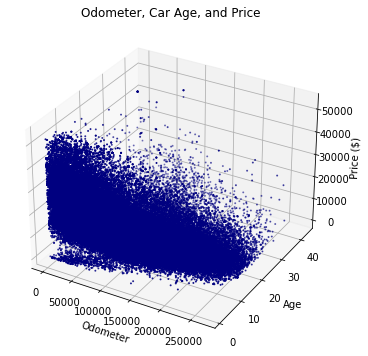

In [43]:
# %matplotlib notebook
# Creating figure
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(car_df['odometer'], car_df['car_Age_in_yrs'], car_df['price'], color = "navy", s=1)
plt.title("Odometer, Car Age, and Price")
ax.set_xlabel('Odometer')
ax.set_ylabel('Age')
#ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Price ($)', rotation = 0)
# show plot
plt.show()

<blockquote>To get a sense of the location of cars for sale in this dataset, the count of cars by state is shown in this plot. California has the most listings followed by Florida.</blockquote>

In [44]:
#Reference:  https://github.com/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb

#convert the state column to all upper case
car_df['state'] = car_df['state'].str.upper() 

#import the coordinates of each state
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"

#create a new dataframe grouped by state and count of vehicles
grp_df = car_df.groupby(["state"], as_index=False)["price"].count()

# Initialize the map:
map = folium.Map([43, -100], zoom_start=4)

folium.Choropleth(
    geo_data=state_geo,
    data=grp_df,
    columns=["state", "price"],
    key_on="feature.id",
).add_to(map)

# Plot the map
map

<blockquote>For Condition of the car, we found it interesting that the excellent_likenew and new categories do not have higher median prices than the good_fair category as indicated by the white circles in the center of each.  This plot also shows that the distribution is heavily skewed below $10,000 for all categories.

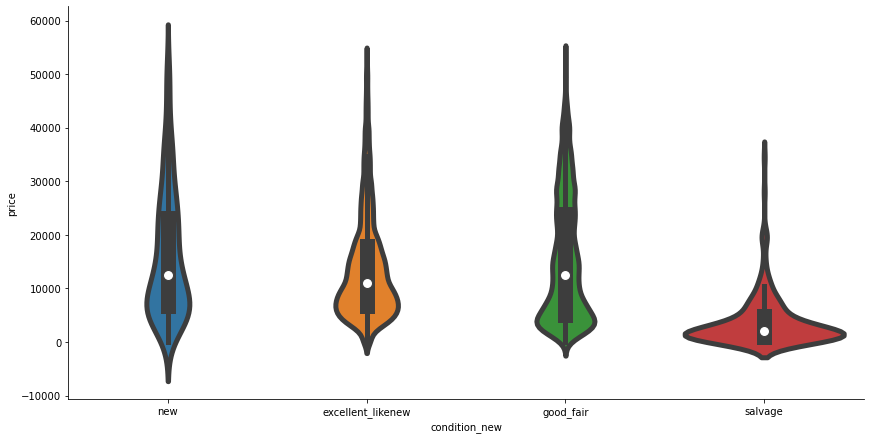

In [45]:
# %matplotlib auto
car_df['condition_new'].value_counts()
#boxplot for condition of car
# fig, axs = plt.subplots(ncols=1, figsize=(10,6))
# ax = sns.boxplot(x="condition_new", y="price", data=car_df).set(title='Condition & Price', xlabel='Condition', ylabel='Price (USD)')
# # Add in points to show each observation
# sns.stripplot(x="condition_new", y="price", data=car_df,
#               jitter=True, size=2, color="slategrey", linewidth=0)

sns.catplot(x="condition_new", y="price", data=car_df, kind='violin',aspect=2,height=6,linewidth=5,
            order=['new','excellent_likenew','good_fair','salvage'])

<blockquote>This plot shows that the majority of observations in the dataset are in the excellent_likenew and good_fair condition categories.

Text(0, 0.5, 'Number of Cars')

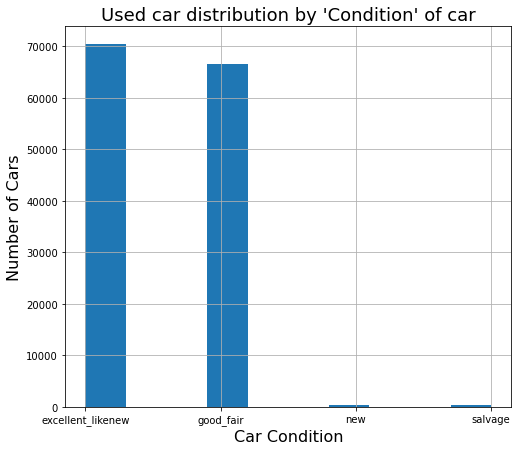

In [46]:
#Plot Used cars distribution in by car type
plt.subplots(figsize = (8,7))
car_df['condition_new'].hist(bins=10)
plt.title("Used car distribution by 'Condition' of car", fontsize=18)
plt.xlabel('Car Condition', fontsize=16)
plt.ylabel('Number of Cars', fontsize=16)

<blockquote>This plot shows that the majority of observations in the dataset are sedans followed by crossover and pickup_truck.

Text(0, 0.5, 'Number of Cars')

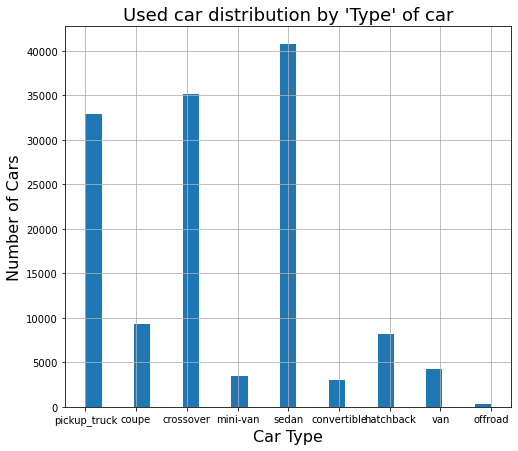

In [47]:
#Plot Used cars distribution in by car type
plt.subplots(figsize = (8,7))
car_df['type_new'].hist(bins=25)
plt.title("Used car distribution by 'Type' of car", fontsize=18)
plt.xlabel('Car Type', fontsize=16)
plt.ylabel('Number of Cars', fontsize=16)

<blockquote>This plot shows that the majority of observations in the dataset are 4-wheel drives and rear-wheel drives.

(array([0, 1, 2, 3]),
 [Text(0, 0, '4wd'),
  Text(1, 0, 'fwd'),
  Text(2, 0, 'rwd'),
  Text(3, 0, 'others')])

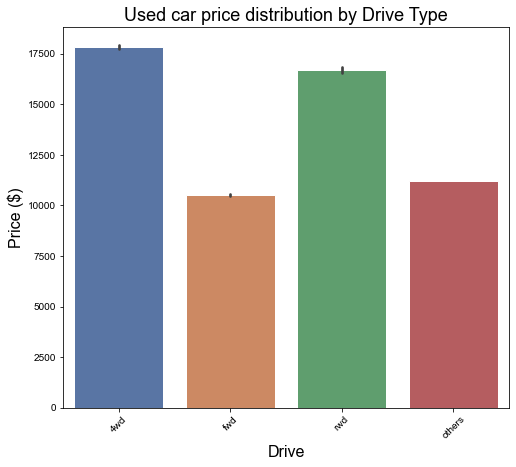

In [48]:
#Histogram for Numbers of cars in each price range by drive
fig, ax = plt.subplots(figsize = (8,7))
sns.set_theme(style="whitegrid")
plt.title("Used car price distribution by Drive Type", fontsize=18)
ax = sns.barplot(y="price", x="drive_new", data=car_df)
ax.set_ylabel('Price ($)', fontsize = 16)
ax.set_xlabel ('Drive', fontsize = 16)
plt.xticks(rotation=45)

# <font color='darkgreen'> Explore Joint Attributes </font>
*Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.*

<blockquote>Correlations<br>
1) A strong negative correlation between Price and Odometer reading. <br>
2) A strong negative correlation between Price and the age of the car. <br>
3) A strong postive correlation between Odometer reading and the age of the car. <br>
4) A slight positive correlation between the number of cyclinders and the price of the car. <br>
5) A very week correlation between the number of cylinders and the age of the car. <br></blockquote
    

<AxesSubplot:>

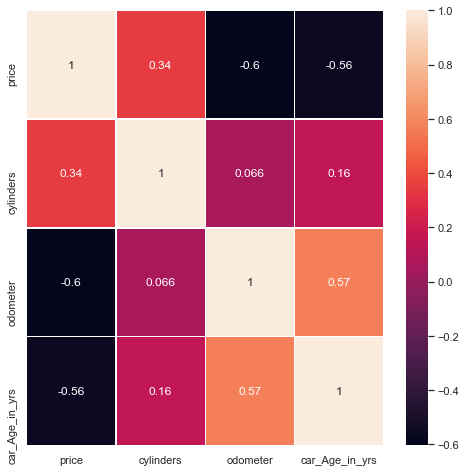

In [49]:
correlations = car_df.corr()
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(correlations, annot=True, linewidths=.5, ax=ax)

<blockquote> California followed by Florida has the most number of 'excellent_likenew' cars for sale on Craigslist for the time period of this dataset.

Text(0.5, 1.0, 'Used cars distribution by State')

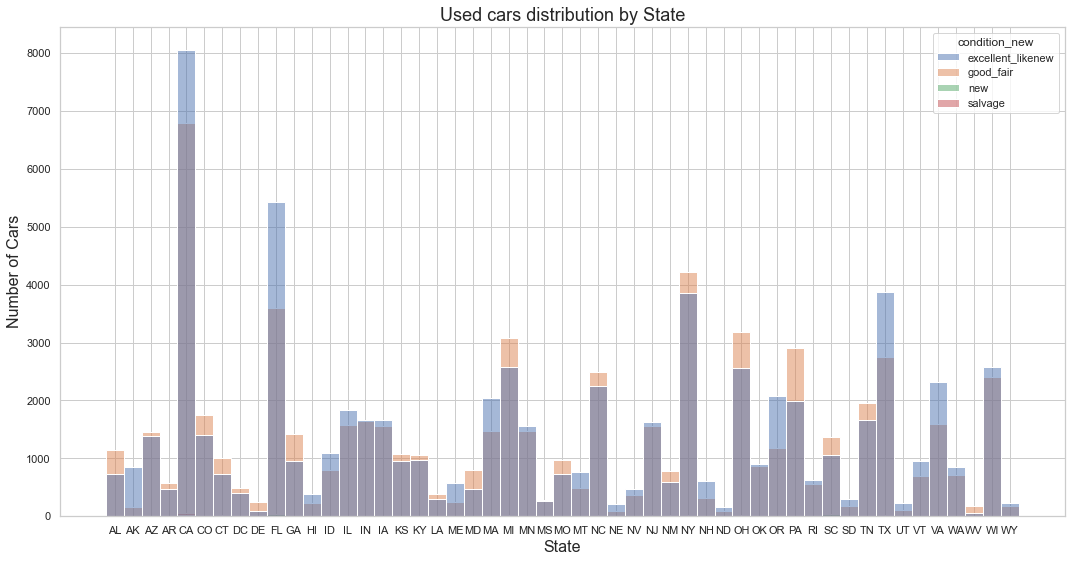

In [50]:
#Plot Used cars distribution by State
fig, ax1 = plt.subplots(figsize = (18,9))
ax1 = sns.histplot(x="state",hue="condition_new", data=car_df)
ax1.set_ylabel('Number of Cars', fontsize = 16)
ax1.set_xlabel ('State', fontsize = 16)
plt.title("Used cars distribution by State", fontsize=18)

<blockquote>Odometer and Car Age are the continuous features in the dataset.  The expectation is that as a car ages, the odometer would increase.  When we break out the data by category we can see this correlation in new and salvaged cars, not those in the excellent_likenew and good_fair categories.    

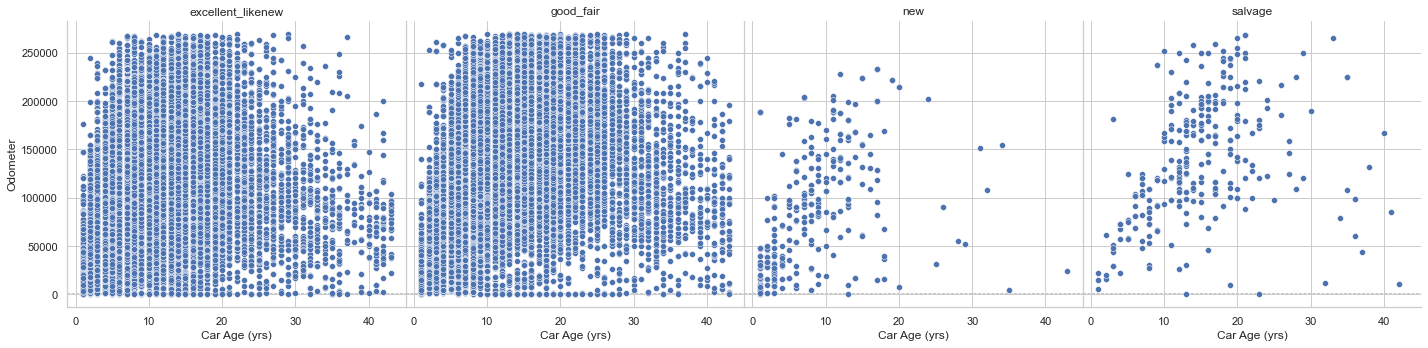

In [51]:
g = sns.relplot(
    data=car_df, x="car_Age_in_yrs", y="odometer",
    col="condition_new",
    kind="scatter",
)
(g.map(plt.axhline, y=0, color=".7", dashes=(2, 1), zorder=0)
  .set_axis_labels("Car Age (yrs)", "Odometer")
  .set_titles("{col_name}")
  .tight_layout(w_pad=0))

<blockquote>This plot shows the proportions of fuel types by vehicle type.  Again, most are gas.  Hatchbacks have the highest proportion of hybrids, followed by sedans.  Pickup trucks, vans, and offroad vehicles have the highest proportion of diesel.  

Text(0.5, 0, 'Car Type')

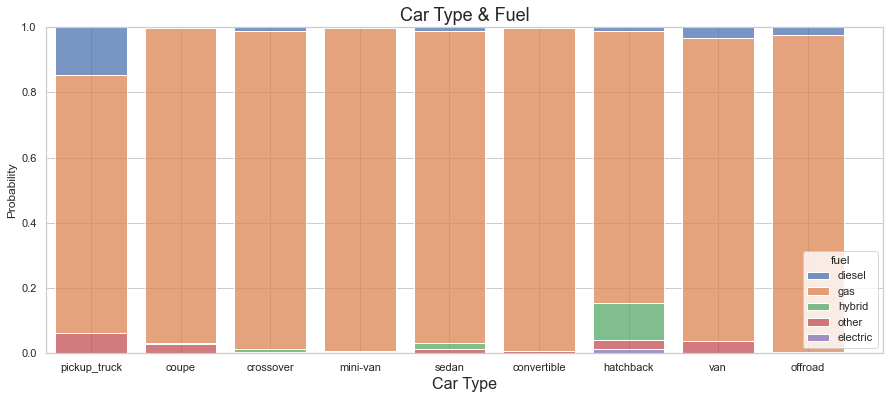

In [52]:
#proportion plot for cylinders and fuel type
fig, axs = plt.subplots(ncols=1,figsize=(15,6))
plt.title("Car Type & Fuel", fontsize=18)
sns.histplot(car_df, x="type_new", hue="fuel", stat="probability", multiple="fill", shrink=.8).set_xlabel('Car Type', fontsize = 16)

<blockquote>This plot shows the proportions of fuel types by manufacturer.  While most of the fuel types in the dataset are classified as gas, we can see which manufacturers have other fuel types.  Tesla of course has the highest percentage of electric cars.  However, more than 50% of Teslas are labeled as having gas fuel.  Since they do not make a gas car, this is likely data entry error.  Ford, Ram, and Volkswagon have the highest percentage of diesel

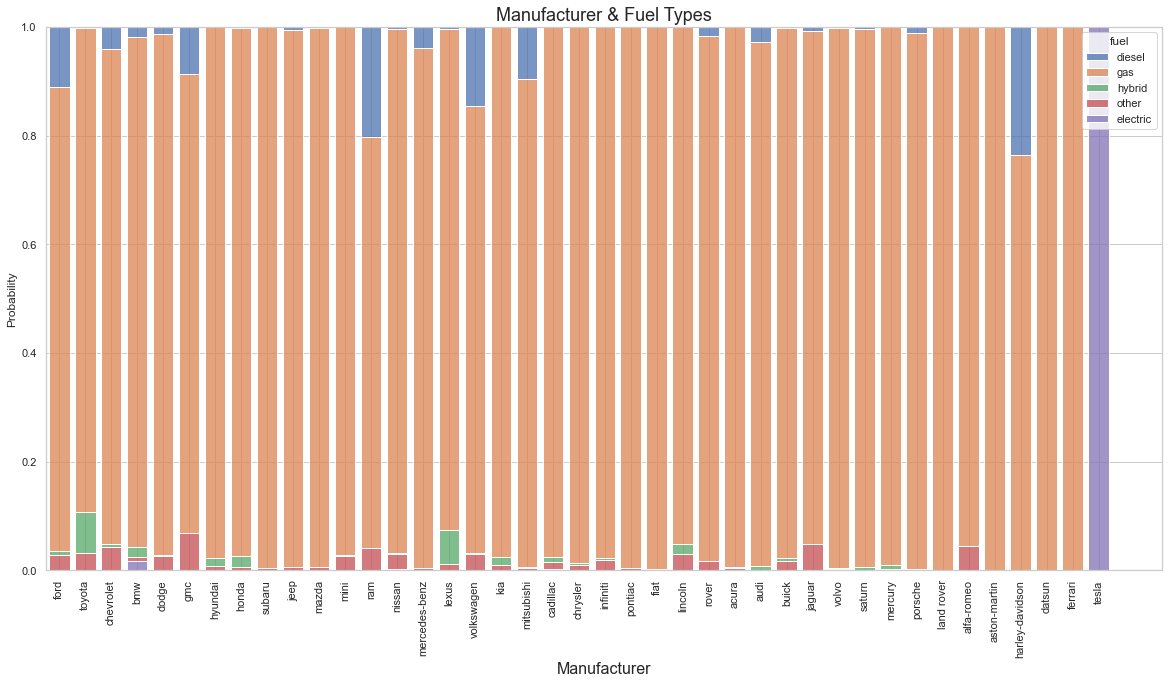

In [53]:
#proportion plot for manufacturer and fuel type
fig, axs = plt.subplots(ncols=1,figsize=(20,10))
plt.title("Manufacturer & Fuel Types", fontsize=18)
sns.histplot(car_df, x="manufacturer", hue="fuel", stat="probability", multiple="fill", shrink=.8).set_xlabel('Manufacturer', fontsize = 16)
plt.xticks(rotation=90)
plt.show()

<blockquote>When exploring the relationship between cylinders and fuel type, we see that 2 cyclinder cars have the highest percentage of non-gasoline fuel types including electric and hybrid.  All of the other cylinders have primarily gas fuel types.  We see some hybrids in the 3 and 4 cylinder cars and diesel fuel types in 4, 5, 6, 7, and 12 cylinder vehicles.

Text(0.5, 0, 'Cylinders')

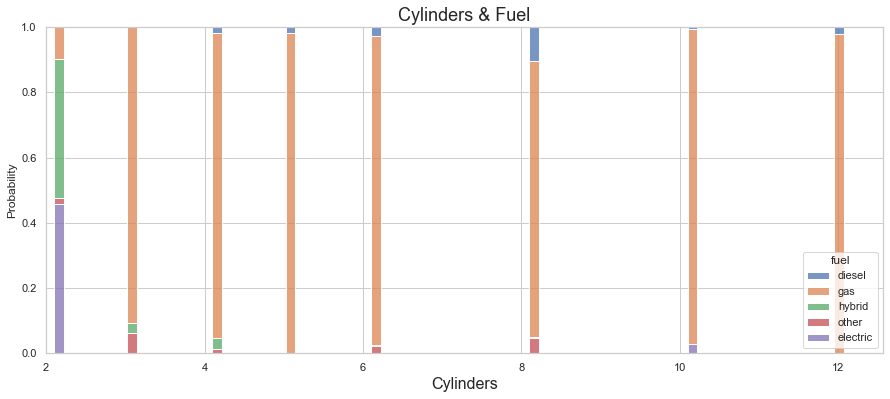

In [54]:
#proportion plot for cylinders and fuel type
fig, axs = plt.subplots(ncols=1,figsize=(15,6))
plt.title("Cylinders & Fuel", fontsize=18)
sns.histplot(car_df, x="cylinders", hue="fuel", stat="probability", multiple="fill", shrink=.8).set_xlabel('Cylinders', fontsize = 16)

<blockquote><b>We observe the following from the plot below:</b><br>

1) For each car type, the cars with the highest odometer reading are in the 'salvage' condition. <br>
2) Off-road vehicles, followed by pickup_trucks and vans have the highest odometer reading for the salvage cars.<br>
3) Convertible cars seem to be inconsistent, with around the same odometer reading, a comparable number of cars are in the 'excellent_likenew' condition or 'salvage' condition.<br>
4) For pick_up trucks, hatchbacks and coupes, the cars in 'excellent_likenew' condition have higher odometer reading compared to these types of cars in 'good/fair' condition. We saw from the plot above that the price for these car types was higher for cars in good/fair condition compared to those in 'excellent/like-new' condition.<p>
Thus condition and car type along with the odometer reading may be good predictors for the price of the car.</blockquote>

Text(0.5, 0, ' Car Type by Condition')

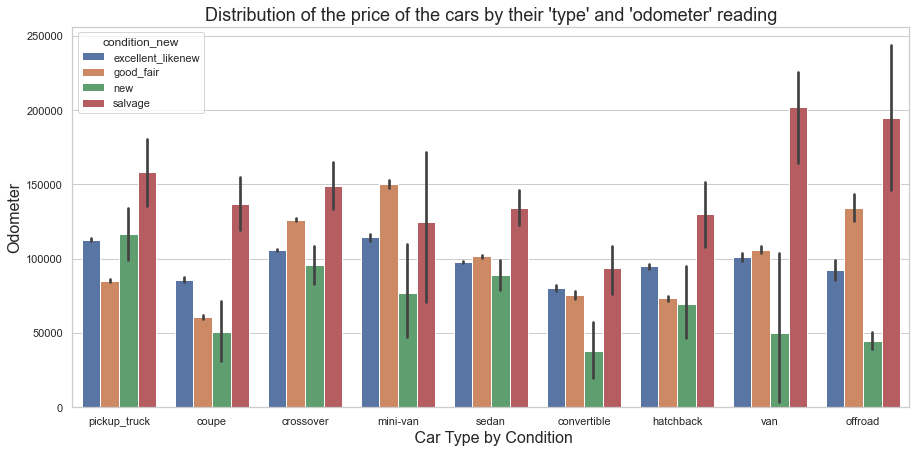

In [55]:
#Distribution of cars by their odometer reading, type and condition
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style="whitegrid")
plt.title("Distribution of the price of the cars by their 'type' and 'odometer' reading", fontsize=18)
ax = sns.barplot(y="odometer",x="type_new", hue="condition_new", data=car_df)
ax.set_ylabel('Odometer', fontsize = 16)
ax.set_xlabel (' Car Type by Condition', fontsize = 16)

# <font color='darkgreen'> Explore Attributes and Class </font>
Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

#### Features and Price (Regression)


<blockquote>There are two continuous features in the dataset - car age in years and odometer.  Prices are trending down as vehicles age and as the mileage increases.  These features are expected to be useful predictors.
   

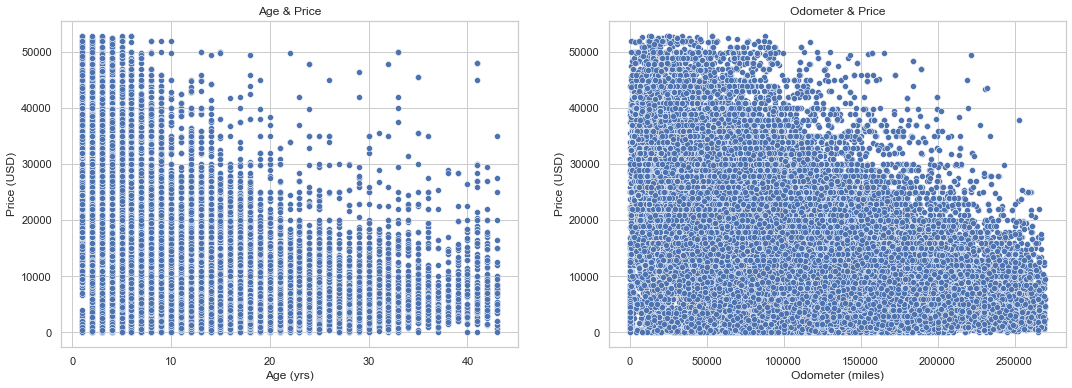

In [56]:
#scatterplots for continuous of car age and odometer by price
fig, axs = plt.subplots(ncols=2, figsize=(18,6))
sns.scatterplot(data=car_df, x="car_Age_in_yrs", y="price", ax=axs[0]).set(title='Age & Price', xlabel='Age (yrs)', ylabel='Price (USD)')
sns.scatterplot(data=car_df, x="odometer", y="price", ax=axs[1]).set(title='Odometer & Price', xlabel='Odometer (miles)', ylabel='Price (USD)')
plt.show()

<blockquote><b>We observe the following from the plot below:</b><p>
1) New cars have the highest prices for cars in each car type. <br>
2) For pickup trucks, hatchbacks and convertible cars, the cars in good_fair condition appear to have higher prices than the cars in excellent_likenew condition for the same car types. Thus, apart from condition and type, there have to be other factors that influence the price of vehicles. <br>
3) Salvage cars have the lowest price for each car type. <br></blockquote>

Text(0.5, 0, ' Car Type by Condition')

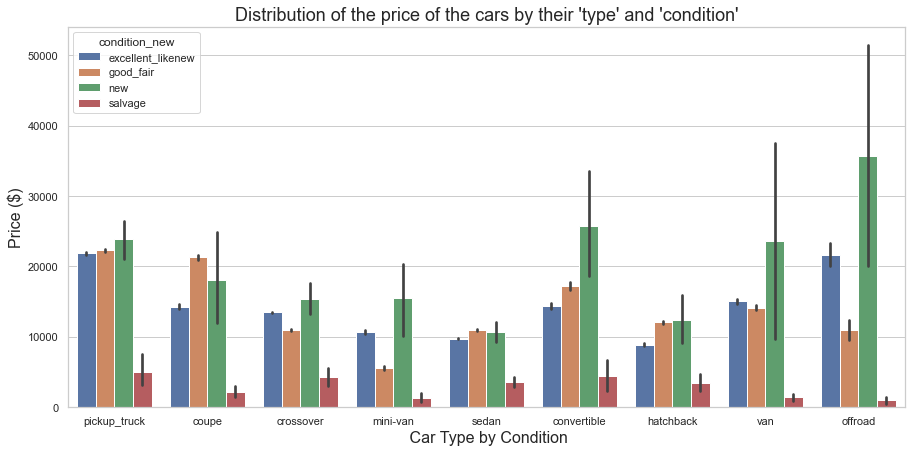

In [57]:
#Histogram for Numbers of cars in each price range by car condition
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style="whitegrid")
plt.title("Distribution of the price of the cars by their 'type' and 'condition'", fontsize=18)
ax = sns.barplot(y="price",x="type_new", hue="condition_new", data=car_df)
ax.set_ylabel('Price ($)', fontsize = 16)
ax.set_xlabel (' Car Type by Condition', fontsize = 16)

<blockquote>High-end manufacturers like Aston-Martin, Ferrari, Porshe, and Tesla have higher prices with medians over $30,000. The manufacturers with the lowest median prices are Mercury, Pontiac, and Saturn.  While the median is high for Tesla, there is a large range of values between the 25th PCTL and the 75th PCTL, indicating that there is a lot of variability in prices for this manufacturer.  We expect this to be a useful feature for prediction.

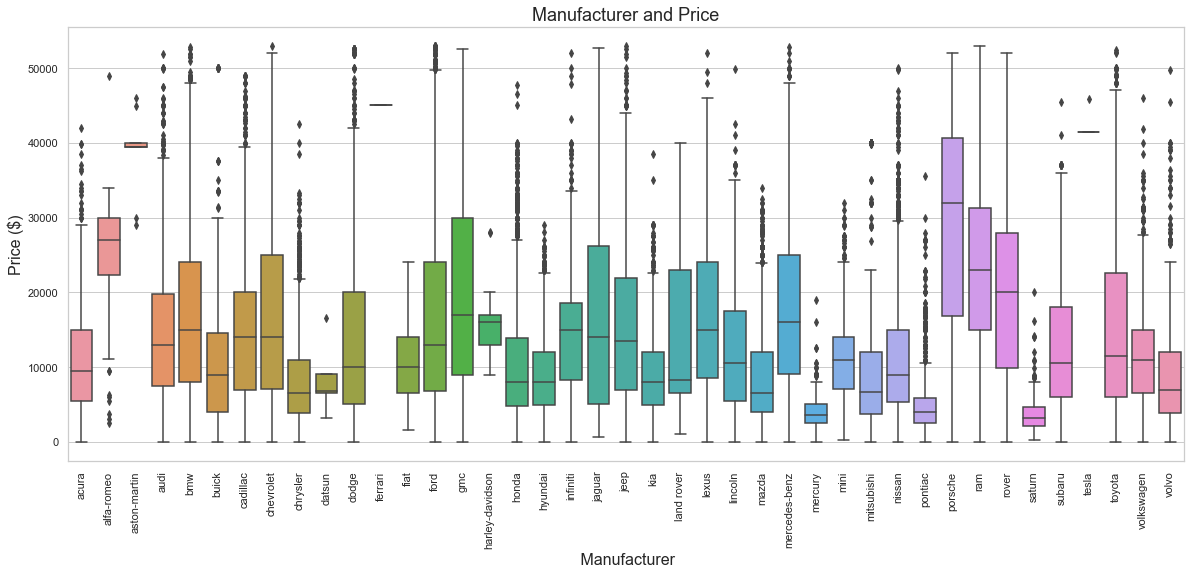

In [58]:
fig, axs = plt.subplots(ncols=1, figsize=(20,8))
plt.title("Manufacturer and Price", fontsize=18)
ax = sns.boxplot(x="manufacturer", y="price", data=car_df.sort_values("manufacturer"))
ax.set_ylabel('Price ($)', fontsize = 16)
ax.set_xlabel (' Manufacturer', fontsize = 16)
plt.xticks(rotation=90)
plt.show()

<blockquote> There does not seem to be much correlation between state and price. West Virginia and Wyoming an could be an exception to this.

Text(0.5, 0, 'State')

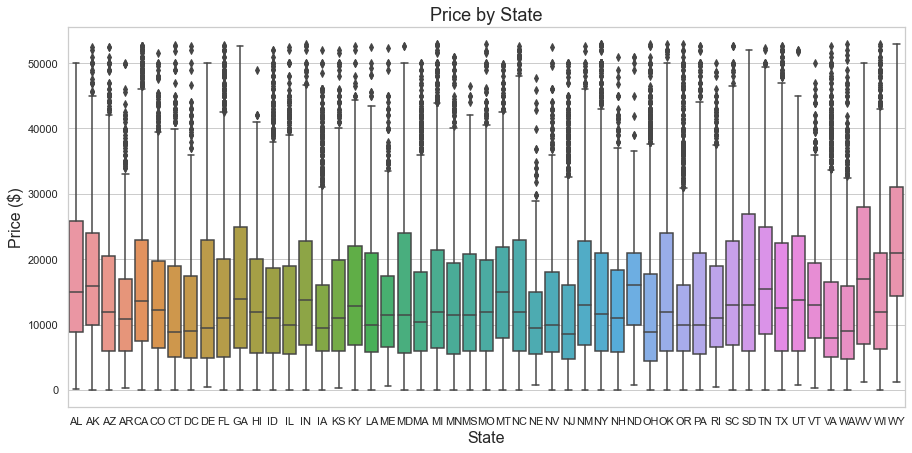

In [59]:
#Price by State
fig, ax = plt.subplots(figsize = (15,7))
sns.set_theme(style="whitegrid")
plt.title("Price by State", fontsize=18)
ax = sns.boxplot(y="price",x="state", data=car_df)
ax.set_ylabel('Price ($)', fontsize = 16)
ax.set_xlabel ('State', fontsize = 16)

<blockquote> Color seems to have small only a minor correlation with price, while transmission seems to have more correlation.

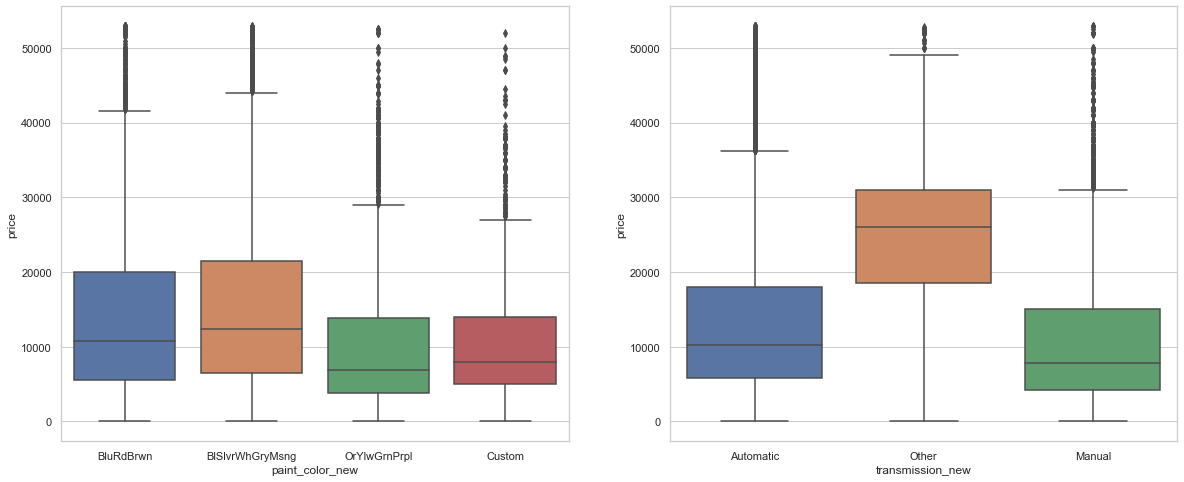

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(20,8))
ax = sns.boxplot(x="paint_color_new", y="price", data=car_df,ax=axs[0])
ax = sns.boxplot(x="transmission_new", y="price", data=car_df,ax=axs[1]) 

#### Categorical Features and Price Range (Classification)

Text(0, 0.5, 'Number of Cars')

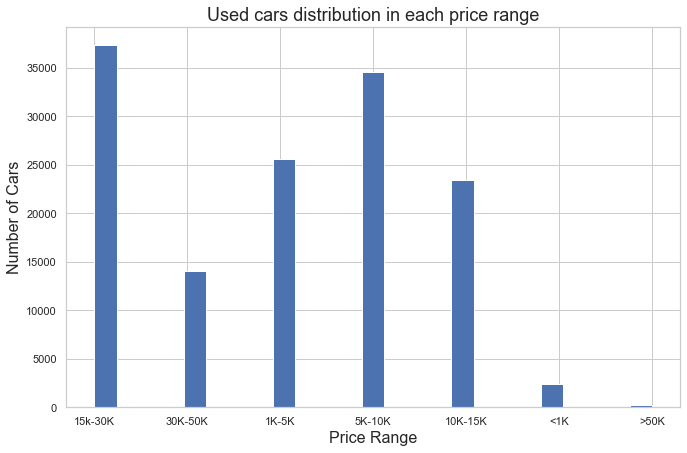

In [61]:
#Plot Used cars distribution in each price range
plt.subplots(figsize = (11,7))
car_df['price_range'].hist(bins=25)
plt.title('Used cars distribution in each price range', fontsize=18)
plt.xlabel('Price Range', fontsize=16)
plt.ylabel('Number of Cars', fontsize=16)

<blockquote> For classification problems, the prices have been binned into price ranges.  Below are the proportions for each price range for some of the categorical variables. <br> 

The Title Status is a legal document that states the legal owner of the car.  95% of the vehicles in this dataset have a clean title.  More than 50% of these vehicles with clean titles are priced between 10k-50k.  A rebuilt title is for a vehicle that has been damaged or totaled.  More than 50% of the vehicles in this dataset with a rebuilt title are 10k or less.  A lien title is one that has an outstanding loan on the vehicle.  The majority of vehicles in that category are listed between 10k - 50k.  A parts only title indicates that the car cannot be registered again.  The majority of listings for parts only titles are less than 1k.  A missing title can mean that the title was damaged or lost, but could also indicate a stolen car.  Most of the cars in this category are between 1k - 5k.

<AxesSubplot:xlabel='title_status', ylabel='Probability'>

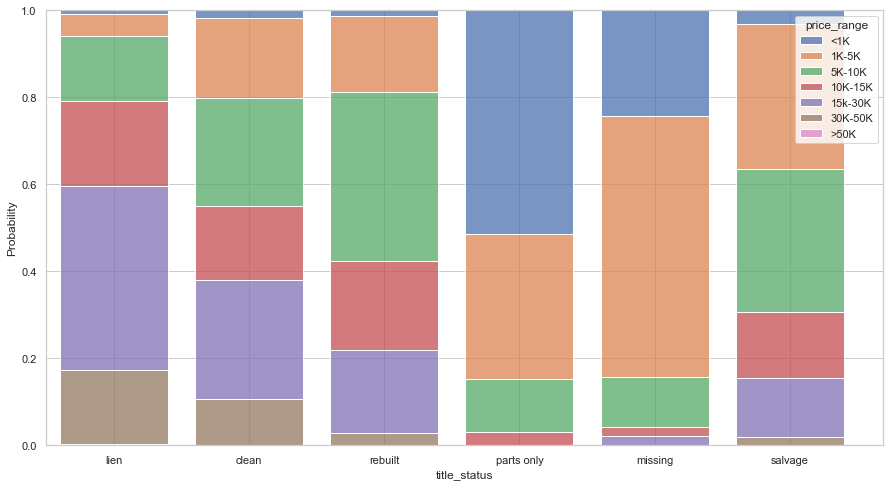

In [62]:
# Draw Seaborn Scatter Plot to find relationship between age and fare
fig, axs = plt.subplots(ncols=1,figsize=(15,8))
sns.histplot(car_df, x="title_status", hue="price_range", stat="probability", multiple="fill", shrink=.8)

<blockquote>For condition of the car, the price ranges are similar for all the conditions except for salvage.  Salvage has a higher proportion of cars that are less than $5,000.  

<AxesSubplot:xlabel='condition_new'>

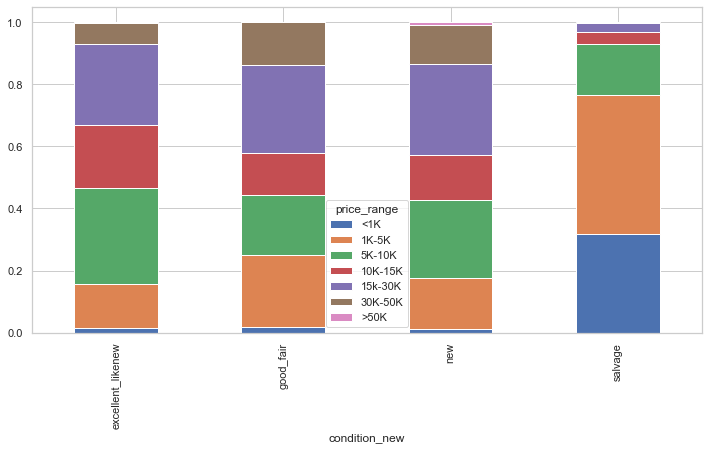

In [63]:
table=pd.crosstab(car_df['condition_new'],car_df['price_range'])
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True, figsize=(12,6),)

<blockquote>When looking at vehicles by the type of fuel, diesel, other, and electric have higher proportions in the USD 15 - 30k range.Hybrids have the highest proportion in the USD 5-10k range.

<AxesSubplot:xlabel='fuel', ylabel='Probability'>

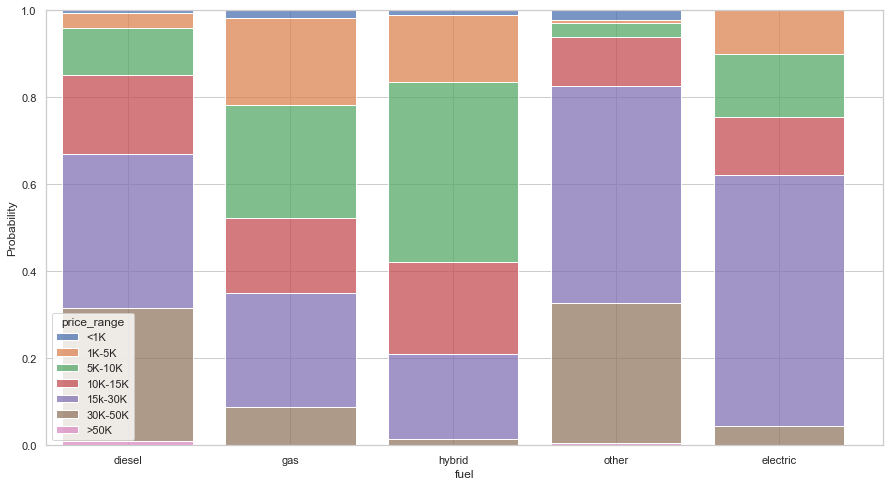

In [64]:
fig, axs = plt.subplots(ncols=1,figsize=(15,8))
sns.histplot(car_df, x="fuel", hue="price_range", stat="probability", multiple="fill", shrink=.8)

<a id="New-Features"></a>

# <font color='darkgreen'>New Features</font>
*Are there other features that could be added to the data or created from existing features? Which ones?*

* We created a new feature column called “car_Age_in_yrs” which is derived by substracting the age of the car from the posting date. This new column will help determine whether there is correlation between the car age and the price of the car, which we believe to be the case.<p> 
    
* We also do the one hot encoding on the categorical feature variables i.e. manufacturer, model, cylinders, fuel, title_status, drive, state, condition_new, transmission_new, type_new, paint_color_new. The feature columns total number grow from 16 columns to 13,196 columns due to this one hot encoding. <p>
    
* Depending on the results of feature selection, we may reduce the states column to larger regions (west coast, east coast, etc.).
    
 

In [65]:
car_df_encoded = pd.get_dummies(car_df[[ 'price', 
                                         'manufacturer', 
                                         'model', 
                                         'cylinders', 
                                         'fuel', 
                                         'odometer',
                                         'title_status', 
                                         'drive_new', 
                                         'state', 
                                         'posting_date', 
                                         'price_range',
                                         'condition_new', 
                                         'transmission_new', 
                                         'type_new', 
                                         'paint_color_new',
                                         'car_Age_in_yrs']])
car_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137526 entries, 4 to 458211
Columns: 12157 entries, price to paint_color_new_OrYlwGrnPrpl
dtypes: datetime64[ns](1), float64(2), int64(2), uint8(12152)
memory usage: 1.6 GB


<a id='exceptional'></a>

# <font color='darkgreen'> Exceptional Work </font>

There were columns in the dataset that had missing values. We extracted the information for these columns using the U.S. Department Of Transportation VIN API. (https://vpic.nhtsa.dot.gov/api/). As a valid VIN number is needed to extract information from this API the entire dataset could not be cleanup as many instances were missing VIN number. The following columns were extracted from the VIN API. A scraper was built to call a ReST endpoint and write the details to a file, which was later joined to the original dataset.



| Attribute | Attribute Description | Imputed Column in the Original Dataset |
| --- | --- | --- | 
|VIN | Unique Vehicle Indentifier for a car | Not Mapped. Used for perform join on dataset
| DriveType | Front Wheel Drive, Rear Wheel Drive, All Wheel Drive, etc.| drive
| EngineCylinders | Number of cylinders in the car| cylinders
| EngineManufacturer | Manufacturer Name, for example Ford, GM, etc.| Not Mapped
| EngineModel | The model of the engine | Not Mapped
| Make | Make of the car. For example Toyota, Hyundai, etc. | Not Mapped 
| Manufacturer | Same as engine Manufacturer, but more detailed name | Not Mapped 
| Model | Model of the car. For example Camry, Sonata, etc.| model
| ModelYear | Model when the car was released| year
| PlantCompanyName | Plant where the engine was manufactured| Not Mapped
| TransmissionSpeeds | How many transmissions are present in the car, for Example 4 Speed, 6 Speed etc.|  Not Mapped |
| TransmissionStyle | Kind of transmission. For example, Automatic , Manual, CVT, etc.| transmission |
| FuelTypePrimary | Fuel type used in the car. For example, Gasoline ,Diesel, etc.| fuel |



In [66]:

# def fetch_vin_details(dataset, attribute):
#     # List of attributes to filter from the REST response
#     vin_attributes = [
#         'VIN',
#         'DriveType',
#         'EngineCylinders',
#         'EngineManufacturer',
#         'EngineModel',
#         'Make',
#         'Manufacturer',
#         'Model',
#         'ModelYear',
#         'PlantCompanyName',
#         'TransmissionSpeeds',
#         'TransmissionStyle',
#         'FuelTypePrimary']

#     #
#     row_list = []
#     request_batch_size = 50
#     current_fetch_size = 0
#     vin_details = ''
#     num_requests = 0

#     # Create VIN batches so that HTTP requests can be batched to reduce network IO calls for faster processing
#     for vin in dataset[attribute]:
#         #
#         if not pd.isnull(vin):
#             #
#             vin_details += vin + ';'
#             current_fetch_size += 1
#             #
#             if current_fetch_size == request_batch_size:
#                 # Introducing a delay to not overload the remote server
#                 if num_requests == 50:
#                     num_requests = 0
#                     print(
#                         'Going to sleep for sometime to avoid connection refused issue')
#                     time.sleep(2)
#                 # Fetch response from API
#                 rows = create_http_request(vin_details, vin_attributes)
#                 vin_details = ''
#                 current_fetch_size = 0
#                 num_requests += 1
#                 row_list.append(rows)

#     # Flush out remaining if last fetch size is fewer than the request batch size
#     if current_fetch_size < request_batch_size:
#         rows = create_http_request(vin_details, vin_attributes)
#     row_list.append(rows)

#     #
#     return row_list


# def create_http_request(vin_batch, attributes):
#     # construct the batched URL for fetching the VIN information from US DOT
#     header = {
#         'Accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
#         'Accept-Encoding': "gzip, deflate, br",
#         'Accept-Language': "en-US,en;q=0.5",
#         'Connection': "keep-alive",
#         'Content-Length': "57",
#         'Content-Type': "application/x-www-form-urlencoded",
#         'Host': "vpic.nhtsa.dot.gov",
#         'Origin': "https://vpic.nhtsa.dot.gov",
#         'Referer': "https://vpic.nhtsa.dot.gov/api/",
#         'Upgrade-Insecure-Requests': "1",
#         'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:84.0) Gecko/20100101 Firefox/84.0"
#     }

#     url = 'https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/'

#     data_dict = {'DATA': vin_batch, 'format': 'JSON'}

#     # Parse the raw response in JSON format
#     response_raw = requests.post(
#         url, headers=header, data=data_dict)

#     # Parse if we get a sucessfull response, else return a null list
#     if not response_raw.status_code == requests.codes.ok:
#         print("Unable to get a reponse at {} for url , {} , {} ".format(
#             datetime.now(), url, response_raw.text))
#         return []

#     #
#     # print(response_raw.text)
#     response_json = json.loads(response_raw.text)

#     with open('vin_data.csv', 'a') as file:
#         # Create a dataframe from the JSON response
#         rows = []
#         for elements in range(0, response_json['Count']):
#             values = []
#             for key in attributes:
#                 values.append(response_json['Results'][elements][key])
#             rows.append(values)
#             file.write("|".join([str(element) for element in values])+"\n")
#             file.flush()
#     #
#     print("Fetched {} records from API at {}".format(len(rows), datetime.now()))
#     file.close()
#     #
#     return rows


# def unpack_list_to_df(row_list):
#     #
#     df_list = []

#     for indx in range(0, len(row_list)):
#         for iter in range(0, len(row_list[indx])):
#             df_list.append(row_list[indx][iter])

#     #
#     return pd.DataFrame(df_list, columns=[
#         'VIN',
#         'DriveType',
#         'EngineCylinders',
#         'EngineManufacturer',
#         'EngineModel',
#         'Make',
#         'Manufacturer',
#         'Model',
#         'ModelYear',
#         'PlantCompanyName',
#         'TransmissionSpeeds',
#         'TransmissionStyle',
#         'FuelTypePrimary'])